In [5]:
import numpy as np
import matplotlib.pyplot as pyplot
from matplotlib.path import Path
import matplotlib.patches as patches

In [238]:
class HMM_Simulator(object):
    
    def __init__(self, map_size, obs_size, obstacles = None):
        
        #### Defining parameters and variables ####
        ## Probability of robot staying in the same state
        self.p_stay = 0.2
        # Probability of robot observing given state correctly
        self.p_truesignal = 0.7
        # Size of the gridworld
        self.map_size = map_size # Size of one edge of grid world
        self.state_size = map_size * map_size # Total number of state
        self.obs_size = obs_size # Total number of observation
        # Noise of the robot
        
        # Transition matrix of the simulator, initilize without any obstacles
        # Size is num_state x num_state
        self.T = np.zeros((self.state_size, self.state_size))
        
        # Observation matrix of the simulator, num_state x num_obs
        self.M = np.zeros((self.state_size, self.obs_size))
        
        # True identity of the states, the index corresponds to the state
        self.S_type = np.random.choice(self.obs_size, self.state_size)
        
        # Keep track of any obstacles
        self.obstacles = obstacles
        ## First classify the states into different types
        self.corner_states = [0, self.map_size - 1, 
                         self.state_size - self.map_size, self.state_size - 1]
        self.north_edge_states = list(range(1, self.map_size-1))
        self.west_edge_states = list(range(self.map_size, self.state_size - self.map_size, 
                                      self.map_size))
        self.east_edge_states = list(range(self.map_size*2-1, self.state_size - self.map_size, 
                                      self.map_size))
        self.south_edge_states = list(range(self.state_size - self.map_size - 1, self.state_size - 1))
        self.middle_states = sorted(list(set(range(self.map_size-1)) - \
                                         set(self.corner_states) - \
                                         set(self.north_edge_states) - \
                                         set(self.west_edge_states) - \
                                         set(self.east_edge_states) - \
                                         set(self.south_edge_states)))
        
        
        #### Updating the matrices according to the map ####
        
        # Fill in the transition matrix
        ## Second iterate through all the states and fill the transition matrix
        ### Determine corner case
        for s in self.corner_states:
            prow = np.zeros(self.state_size)
            prow[s] = self.p_stay + (1.0 - self.p_stay) / 2
            if s == 0:
                prow[1] = (1.0 - self.p_stay) / 4.0
                prow[self.map_size] = (1.0 - self.p_stay) / 4.0
            elif s == (self.map_size-1):
                prow[self.map_size - 2] = (1.0 - self.p_stay) / 4.0
                prow[s + self.map_size] = (1.0 - self.p_stay) / 4.0
            elif s == (self.state_size - self.map_size - 1):
                prow[self.state_size - 2*self.map_size] = (1.0 - self.p_stay) / 4.0
                prow[self.state_size - 2*self.map_size + 1] = (1.0 - self.p_stay) / 4.0
            else:
                prow[self.state_size - 2] = (1.0 - self.p_stay) / 4.0
                prow[self.state_size - self.map_size - 1] = (1.0 - self.p_stay) / 4.0
                
            self.T[s,:] = prow
            
        ### Determine the rest
        for s in range(self.state_size):
            if s in self.corner_states:
                continue;
            prow = np.zeros(self.state_size)
            if s in self.north_edge_states:
                prow[s] = self.p_stay + (1.0 - self.p_stay) / 4
                prow[s-1] = (1.0 - self.p_stay) / 4
                prow[s+1] = (1.0 - self.p_stay) / 4
                prow[s+self.map_size] = (1.0 - self.p_stay) / 4
            elif s in self.east_edge_states:
                prow[s] = self.p_stay + (1.0 - self.p_stay) / 4
                prow[s-self.map_size] = (1.0 - self.p_stay) / 4
                prow[s-1] = (1.0 - self.p_stay) / 4
                prow[s+self.map_size] = (1.0 - self.p_stay) / 4
            elif s in self.west_edge_states:
                prow[s] = self.p_stay + (1.0 - self.p_stay) / 4
                prow[s-self.map_size] = (1.0 - self.p_stay) / 4
                prow[s+1] = (1.0 - self.p_stay) / 4
                prow[s+self.map_size] = (1.0 - self.p_stay) / 4
            elif s in self.south_edge_states:
                prow[s] = self.p_stay + (1.0 - self.p_stay) / 4
                prow[s-self.map_size] = (1.0 - self.p_stay) / 4
                prow[s+1] = (1.0 - self.p_stay) / 4
                prow[s-1] = (1.0 - self.p_stay) / 4
            else:
                prow[s] = self.p_stay
                prow[s-self.map_size] = (1.0 - self.p_stay) / 4
                prow[s+1] = (1.0 - self.p_stay) / 4
                prow[s-1] = (1.0 - self.p_stay) / 4
                prow[s+self.map_size] = (1.0 - self.p_stay) / 4
            
            self.T[s,:] = prow
        
        # Fill in the observation matrix
        for i in range(self.state_size):
            m_row = np.array([0.7 if k == self.S_type[i] else 
                              0.3/(self.obs_size-1) for k in range(self.obs_size)])
            self.M[i,:] = m_row
        
        
    # Generate data randomly, robot will go to any station uniformly
    # and observe the state according to M matrix
    # Return the true state locations and the observation at give time t
    def random_generate(self, N):
        if self.obstacles is None:
            non_obstacles = list(set(range(self.state_size)))
        else:
            non_obstacles = list(set(range(self.state_size)) - set(self.obstacles))

        Z = np.zeros(N)
        X = np.random.choice(non_obstacles, N)
        for t in range(N):
            Z[t] = np.random.choice(list(range(self.obs_size)), 1, p=self.M[X[t],:])
            
        return (X, Z)
            
    # Generate the data according to the transition matrix,
    # The robot moves one state at a time and observe one observation at a time
    # Return the true state locations and the observation at given time t
    # Robot starts at a random location
    def normal_generate(self, N):
        Z = np.zeros(N)
        X = np.zeros(N)
        if self.obstacles is None:
            non_obstacles = list(set(range(self.state_size)))
        else:
            non_obstacles = list(set(range(self.state_size)) - set(self.obstacles))
                                 
        current_state = np.random.choice(non_obstacles, 1)[0]
                                 
        for t in range(N):
            current_state = np.random.choice(list(range(self.state_size)), 1, p=self.T[current_state,:])[0]
            X[t] = current_state
            Z[t] = np.random.choice(list(range(self.obs_size)), 1, p=self.M[int(X[t]),:])
        
        return (X, Z)
    
    # Generate the data when there is correlation between more than one past states
    # to the next movement
    # Correlation structure - everytime the robot moves we select from a new transition matrix
    def corr_generate(self, N):
        return
    
    def perturb_transition(self):
        if self.obstacles is None:
            non_obstacles = list(set(range(self.state_size)))
        else:
            non_obstacles = list(set(range(self.state_size)) - set(self.obstacles))
        
        for s in non_obstacles:
            new_prob = np.copy(self.T[s,:])
            new_prob[s] = round(np.random.uniform(0.1, 0.3), 2)
            available = np.where(new_prob != 0)[0]
            # Perturb the prob of staying in by uniform
            diff = (self.T[s,s] - new_prob[s]) / (len(available) - 1)
            for j in available:
                if s != j:
                    new_prob[j] += diff
            self.T[s,:] = new_prob
            
        return
    
    # Fill the world with random obstacles of given size
    # Adjust T and M accordingly
    def fill_random_obstacle(self, num_obstacles):
                                 
        if num_obstacles > self.state_size:
            raise NameError("Too Many Obstacles!")
        
        valid_map = False
        
        while not valid_map:
            new_M = np.copy(self.M)
            new_T = np.copy(self.T)
            new_obstacles = sorted(np.random.choice(list(range(self.state_size)), num_obstacles, replace=False))

            for o in new_obstacles:
                contig = sorted(self.find_contiguous_state(o))
                for c in contig:
                    if c in new_obstacles:
                        continue
                    else:
                        new_T[c,c] += new_T[c,o]
                        new_T[c,o] = 0
                        new_M[o,:] = 0
            # Check whether the new map candidate is valid
            if (new_T != 1).all():
                valid_map = True
            
        self.M = new_M
        self.T = new_T
        self.obstacles = new_obstacles
            
        return
    
    
    ## Return the states that are continguous to give state
    def find_contiguous_state(self, s):
        contiguous = []
                                 
        if (s % self.map_size != 0):
            contiguous.append(s - 1)
        
        if ((s+1) % self.map_size != 0 ):
            contiguous.append(s + 1)
        
        if (s - self.map_size > 0):
            contiguous.append(s - self.map_size)
    
        if (s + self.map_size < self.state_size):
            contiguous.append(s + self.map_size)
                                 
        return(contiguous)
        
    
    # Show the map
    def draw_world(self):
        
        if self.obstacles is None:
            non_obstacles = list(set(range(self.state_size)))
        else:
            non_obstacles = list(set(range(self.state_size)) - set(self.obstacles))
            
        fig = pyplot.figure()
        ax = fig.add_subplot(111)

        ax.tick_params(
            axis='both',
            which='both',
            bottom=False,
            top=False,
            left=False,
            labelbottom=False,
            labelleft=False)

        size = 10
        for i in range(self.map_size+1):
            ax.plot([0,self.map_size*size],[i*size,i*size],'k-')

        for i in range(self.map_size+1):
            ax.plot([i*size,i*size],[0,self.map_size*size],'k-')
        
        if self.obstacles is not None:
            for s in self.obstacles:
            # Draw the obstacles
                x = s % self.map_size
                y = self.map_size - s // self.map_size -1
                verts = [
                    (x*size,y*size),
                    (x*size,(y+1)*size),
                    ((x+1)*size,(y+1)*size),
                    ((x+1)*size,y*size),
                    (x*size,y*size),
                ]

                codes = [Path.MOVETO,
                    Path.LINETO,
                    Path.LINETO,
                    Path.LINETO,
                    Path.CLOSEPOLY,
                 ]

                path = Path(verts, codes)

                patch = patches.PathPatch(path, facecolor='black', lw=1)
                ax.add_patch(patch)
            
        for s in non_obstacles:
            x = s % self.map_size
            y = self.map_size - s // self.map_size -1
            name = self.S_type[s]
            ax.text((x+0.4)*size, (y+0.45)*size, name)
        
        pyplot.show()
        

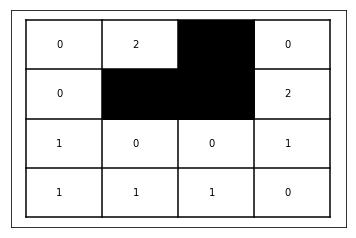

In [239]:
# Generate HMM map with (size of maps edge, number of state types)
h = HMM_Simulator(4, 3, obstacles=[2,5,6])
# Fill the map with random obstacles
h.perturb_transition()
# Look at the map
h.draw_world()

In [240]:
np.sum(h.T, axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

array([[0.7 , 0.15, 0.15],
       [0.15, 0.15, 0.7 ],
       [0.  , 0.  , 0.  ],
       [0.15, 0.7 , 0.15],
       [0.7 , 0.15, 0.15],
       [0.  , 0.  , 0.  ],
       [0.7 , 0.15, 0.15],
       [0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  ],
       [0.7 , 0.15, 0.15],
       [0.15, 0.15, 0.7 ],
       [0.15, 0.7 , 0.15],
       [0.15, 0.7 , 0.15],
       [0.  , 0.  , 0.  ],
       [0.15, 0.15, 0.7 ]])

In [146]:
current_state[0]

1

In [219]:
a = np.array([0.1,1,0,0,0,0.2,0,0,0.3,0,0])
a

array([0.1, 1. , 0. , 0. , 0. , 0.2, 0. , 0. , 0.3, 0. , 0. ])